In [1]:
import xarray as xr
#from aostools.climate import ComputeMeridionalPVGrad, ComputeRefractiveIndex, ComputeEPfluxDiv
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs
#import shapely.geometry as sgeom
#import glob
#from averaging import xarray_average
#import xarray.ufuncs as xrf
#import detect_peaks as dp
#from bokeh.plotting import figure, output_file, show, output_notebook
#from bokeh.models import HoverTool, ColumnDataSource, CrosshairTool
import pandas as pd
#import peakutils.peak
import shapely.geometry as sgeom
from string import ascii_lowercase, ascii_uppercase
from statsmodels.stats.multitest import fdrcorrection

%matplotlib inline

# Options

In [2]:
plt.rcParams.update({'font.size': 22})
xr.set_options(keep_attrs=True,display_style='html')

In [3]:
timescale = 20
DJF_bool = '_DJFonly'
root_path = '/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/'
root_path = '/mnt/data04/model/CMAM/0A.daily/'
cesta = f'{root_path}composites_woSSW{DJF_bool}/'

In [4]:
var = 'lwa_logH'
what = 'anomalies'#'percentages' A
e_type = 'himalayas'
timescale = 20

In [5]:
if e_type == 'himalayas':
    box = sgeom.box(minx=70, maxx=102.5, miny=20, maxy=40)
    zoomin_extent = [0,180,10,80]
    central_longitude = 90

elif e_type == 'eastasia':
    box = sgeom.box(minx=110, maxx=145, miny=27.5, maxy=52)
    zoomin_extent = [0,180,10,80]
    central_longitude = 90

elif e_type == 'westamer':
    box = sgeom.box(minx=-125, maxx=-102.5, miny=27.5, maxy=52)
    zoomin_extent = [-180,0,10,80]
    central_longitude = 270
    
box_lats = np.array(box.bounds)[1::2]
box_lons = np.array(box.bounds)[::2]
box_lons[box_lons < 0] += 360

# Data loading

In [6]:
infile = '{}{}_{}_comp_{}_{}days.nc'.format(cesta, var, what, e_type, timescale)
print(infile)
da = xr.open_dataarray(infile)
da.attrs['units'] = 'm/s'
da.attrs['long_name'] = 'LWA'
da

/mnt/data04/model/CMAM/0A.daily/composites_woSSW_DJFonly/lwa_logH_anomalies_comp_himalayas_20days.nc


<xarray.DataArray 'lwa' (lag: 21, z: 39, lat: 48, lon: 96)>
[3773952 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * z        (z) float64 2e+03 4e+03 6e+03 8e+03 ... 7.4e+04 7.6e+04 7.8e+04
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
Attributes:
    units:      m/s
    long_name:  LWA

In [7]:
its = 10000
da_pv = xr.open_dataarray(f'{cesta}{var}_pvalues_from{its}_comp_{e_type}_{timescale}days@18000m.nc')
da_pv

<xarray.DataArray (lat: 48, lon: 96, lag: 21)>
array([[[7.073534, 7.142642, ..., 6.546188, 7.233652],
        [7.266996, 6.923374, ..., 6.781337, 7.237314],
        ...,
        [5.526175, 7.159032, ..., 7.163106, 6.955323],
        [5.975059, 7.250798, ..., 7.158576, 7.024269]],

       [[2.346776, 2.30183 , ..., 2.168045, 2.353254],
        [2.326103, 2.259593, ..., 2.114586, 2.416483],
        ...,
        [1.628295, 2.323476, ..., 2.299797, 2.303057],
        [2.119192, 2.320774, ..., 2.337962, 2.324307]],

       ...,

       [[1.217792, 2.212021, ..., 1.015946, 0.182602],
        [0.997653, 2.122028, ..., 1.119299, 0.26855 ],
        ...,
        [1.706186, 2.750714, ..., 0.646141, 0.060673],
        [1.523543, 2.38659 , ..., 0.936424, 0.07628 ]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]]])
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
    z        float64 ...
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10

# Visualization

In [8]:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"
weights


<xarray.DataArray 'weights' (lat: 48)>
array([0.04956284, 0.11356847, 0.17747903, 0.24073214, 0.30300897,
       0.36403136, 0.42353629, 0.48127071, 0.53699055, 0.59046096,
       0.64145695, 0.68976415, 0.7351796 , 0.77751257, 0.81658534,
       0.85223389, 0.88430859, 0.91267484, 0.9372136 , 0.95782191,
       0.97441328, 0.98691811, 0.99528392, 0.99947562, 0.99947562,
       0.99528392, 0.98691811, 0.97441328, 0.95782191, 0.9372136 ,
       0.91267484, 0.88430859, 0.85223389, 0.81658534, 0.77751257,
       0.7351796 , 0.68976415, 0.64145695, 0.59046096, 0.53699055,
       0.48127071, 0.42353629, 0.36403136, 0.30300897, 0.24073214,
       0.17747903, 0.11356847, 0.04956284])
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      latitude
    standard_name:  latitude

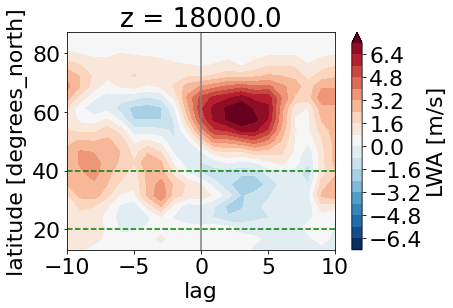

In [20]:
da.sel(
    z = 18000,
    lon = slice(80,130),
    lat = slice(10,None)
).weighted(weights).mean('lon').plot.contourf(
    x = 'lag', 
    levels = 21,
    robust = True
)
plt.hlines(list(box.bounds)[1::2],-10,10, color = 'green', linestyles='--')
plt.vlines(0,13,87, color ='gray')

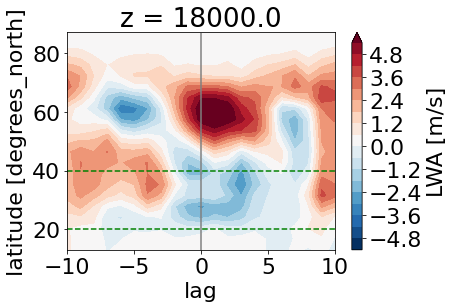

In [22]:
da.sel(
    z = 18000,
    lon = slice(70,105),
    lat = slice(10,None)
).weighted(weights).mean('lon').plot.contourf(
    x = 'lag', 
    levels = 21,
    robust = True
)
plt.hlines(list(box.bounds)[1::2],-10,10, color = 'green', linestyles='--')
plt.vlines(0,13,87, color ='gray')

## Maps

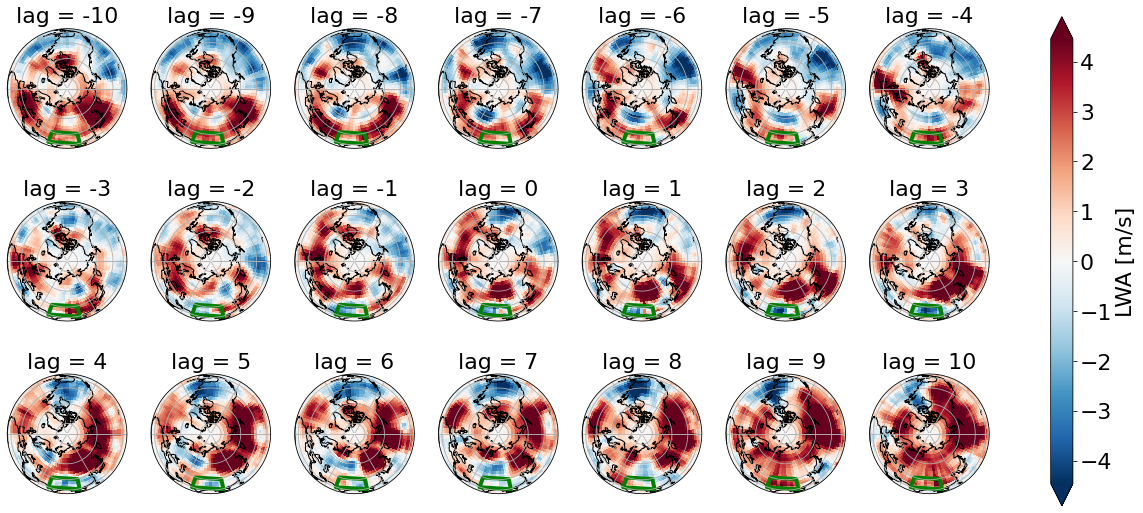

In [24]:
projection = ccrs.Orthographic(central_longitude, 90)
p = da.sel(z = 18000).plot(col = 'lag', col_wrap=7, transform=ccrs.PlateCarree(), \
            subplot_kws={'projection': projection}, robust = True)


for ax, sel_dict in zip(p.axes.flat, p.name_dicts.flat):
    ax.coastlines()
    ax.gridlines()
    ax.add_geometries([box], ccrs.PlateCarree(), \
                      facecolor=['none'], edgecolor=['green'], \
                      linewidth = [4])
    plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False,
                     ax=ax,  transform=ccrs.PlateCarree())
    #da_pv.sel(**sel_dict).plot.contourf(**plot_kwargs)
    plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], \
                                    colors='none', add_colorbar=False,
                        ax=ax,  transform=ccrs.PlateCarree())
    #da_pv.sel(**sel_dict).plot.contourf(**plot_kwargs)
    

### Selected lags

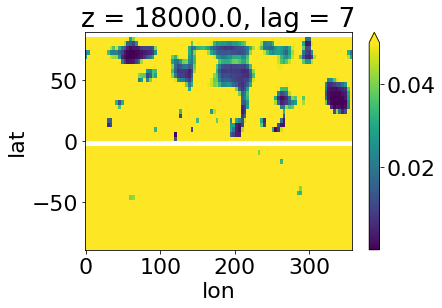

In [15]:
da_pv.sel(**sel_dict).plot(vmax = 0.05)

In [19]:
da_pv.sel(**sel_dict).reset_coords(drop=True)#.plot.contourf(**plot_kwargs) 

<xarray.DataArray (lat: 48, lon: 96)>
array([[7.082502, 7.127192, 7.251713, ..., 6.927703, 7.066063, 7.100358],
       [1.921476, 1.887451, 1.992165, ..., 1.945682, 1.846378, 1.94256 ],
       [0.869122, 0.715327, 0.713902, ..., 0.92564 , 0.998061, 0.969396],
       ...,
       [0.111498, 0.133176, 0.21104 , ..., 0.170417, 0.13682 , 0.09743 ],
       [0.224908, 0.414809, 0.517112, ..., 0.234008, 0.251505, 0.156395],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/xarray/plot/facetgrid.py:394: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


lwa_logH_anomalies_lagA.pdf


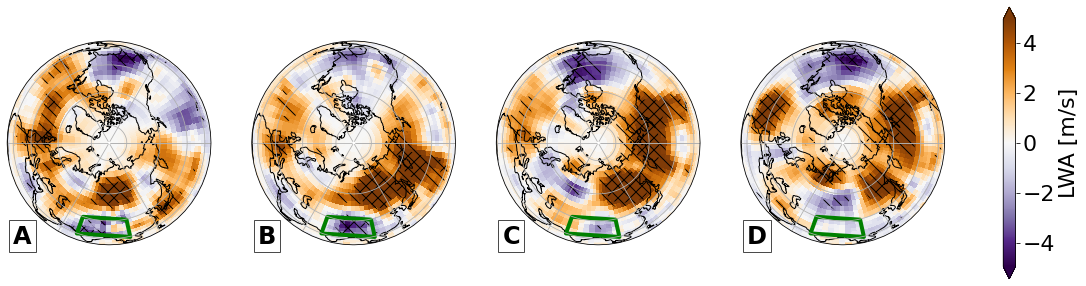

In [21]:
projection = ccrs.Orthographic(central_longitude, 90)
cmap = mpl.cm.PuOr_r#RdBu_
p = da.sel(
    z = 18000,
    lag = [0,3,5,7]
).plot(
    col = 'lag', 
    size = 5, 
    transform=ccrs.PlateCarree(), 
    subplot_kws={'projection': projection}, 
    robust = True,
    cmap = cmap
)


for i, (ax, sel_dict) in enumerate(zip(p.axes.flat, p.name_dicts.flat)):
    ax.coastlines()
    ax.gridlines()
    ax.add_geometries([box], ccrs.PlateCarree(), \
                      facecolor=['none'], edgecolor=['green'], \
                      linewidth = [4])
    
    #if i == 0:
    plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False,
                     ax=ax,  transform=ccrs.PlateCarree())

    da_pv.sel(**sel_dict).reset_coords(drop=True).plot.contourf(**plot_kwargs) # 
    plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], \
                                    colors='none', add_colorbar=False,
                        ax=ax,  transform=ccrs.PlateCarree())
    da_pv.sel(**sel_dict).reset_coords(drop=True).plot.contourf(**plot_kwargs) # .sel(**sel_dict)
    
    ax.text(0.03, 0.1, ascii_uppercase[i], transform=ax.transAxes,
                      fontsize=24, fontweight='bold', va='top', 
            bbox={'alpha': 0.7, 'facecolor': 'white'})
    
outfile = f'{var}_anomalies_lagA.pdf' # _FDR
print(outfile)
#plt.savefig(outfile, bbox_inches = 'tight')    

#### FDR

In [15]:
temp

<xarray.DataArray 'toz' (z: 18432)>
array([0.07585462, 0.0763558 , 0.07686099, ..., 0.00026979, 0.00027023,
       0.00026534])
Coordinates:
  * z        (z) MultiIndex
  - lag      (z) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 7 7 7 7 7 7 7 7 7 7 7
  - lat      (z) float64 -87.16 -87.16 -87.16 -87.16 ... 87.16 87.16 87.16 87.16
  - lon      (z) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

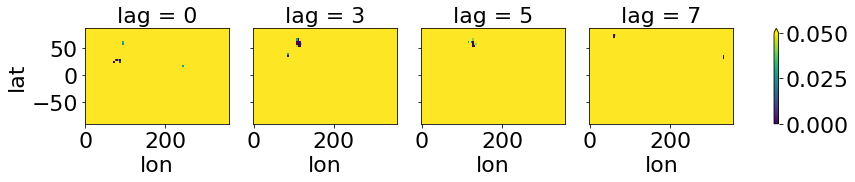

In [35]:
fdr_pv.plot(col ='lag', vmax = 0.05)

In [26]:
da_pv

<xarray.DataArray (lat: 48, lon: 96, lag: 21)>
array([[[7.073534, 7.142642, ..., 6.546188, 7.233652],
        [7.266996, 6.923374, ..., 6.781337, 7.237314],
        ...,
        [5.526175, 7.159032, ..., 7.163106, 6.955323],
        [5.975059, 7.250798, ..., 7.158576, 7.024269]],

       [[2.346776, 2.30183 , ..., 2.168045, 2.353254],
        [2.326103, 2.259593, ..., 2.114586, 2.416483],
        ...,
        [1.628295, 2.323476, ..., 2.299797, 2.303057],
        [2.119192, 2.320774, ..., 2.337962, 2.324307]],

       ...,

       [[1.217792, 2.212021, ..., 1.015946, 0.182602],
        [0.997653, 2.122028, ..., 1.119299, 0.26855 ],
        ...,
        [1.706186, 2.750714, ..., 0.646141, 0.060673],
        [1.523543, 2.38659 , ..., 0.936424, 0.07628 ]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]]])
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
    z        float64 1.8e+04
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10

In [32]:
temp = da_pv.sel(lag = [0,3,5,7]).stack(
    z=('lag','lat', 'lon')
).dropna('z')
fdr = fdrcorrection(temp)
fdr_pv = xr.DataArray(fdr[1], coords = temp.coords).unstack()
fdr_pv

<xarray.DataArray (lag: 4, lat: 46, lon: 96)>
array([[[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        ...,
        [0.68251029, 0.64328574, 0.702646  , ..., 0.72056852,
         0.64651277, 0.61302908],
        [1.        , 0.98021093, 0.9847224 , ..., 1.        ,
         1.        , 0.96884429],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ]],

       [[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [0.71783205, 1.        , 0.99458852, ..., 0.94722832,
         0.69485262, 0.58733585],
...
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ]],

       [[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 0.89108145, 0.88980805, ..., 1.        ,
         1.        , 1.        ],
        ...,
        [0.50343092, 0.50343092, 0.50343092, ..., 0.50343092,
         0.50343092, 0.50343092],
        [0.50343092, 0.50343092, 0.50343092, ..., 0.50343092,
         0.50343092, 0.50343092],
        [0.50343092, 0.61796331, 0.71590724, ..., 0.50343092,
         0.50343092, 0.50343092]]])
Coordinates:
  * lag      (lag) int64 0 3 5 7
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 76.07 79.78 83.48
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/xarray/plot/facetgrid.py:394: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


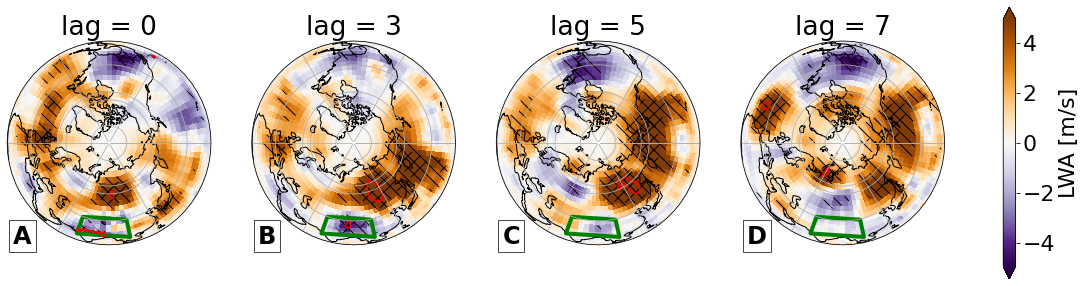

In [39]:
projection = ccrs.Orthographic(central_longitude, 90)
p = da.sel(
    lag = [0,3,5,7],
    z = 18000,
).plot(
    col = 'lag', 
    size = 5, 
    transform=ccrs.PlateCarree(), 
    subplot_kws={'projection': projection}, 
    robust = True,
    cmap = cmap,
)


for i, (ax, sel_dict) in enumerate(zip(p.axes.flat, p.name_dicts.flat)):
    ax.coastlines()
    ax.gridlines(ylocs=[40,60,65,80])
    ax.add_geometries([box], ccrs.PlateCarree(), \
                      facecolor=['none'], edgecolor=['green'], \
                      linewidth = [4])
    plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False,
                     ax=ax,  transform=ccrs.PlateCarree())
    da_pv.sel(**sel_dict).plot.contourf(**plot_kwargs)
    plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], \
                                    colors='none', add_colorbar=False,
                        ax=ax,  transform=ccrs.PlateCarree())
    da_pv.sel(**sel_dict).plot.contourf(**plot_kwargs)
    plot_kwargs = dict(levels = [0,0.05], colors='r', \
                           add_colorbar=False, \
                        ax=ax,  transform=ccrs.PlateCarree())
    fdr_pv.sel(**sel_dict).plot.contour(**plot_kwargs)
    
    ax.text(0.03, 0.1, ascii_uppercase[i], transform=ax.transAxes,
                      fontsize=24, fontweight='bold', va='top', 
            bbox={'alpha': 0.7, 'facecolor': 'white'})
plt.savefig('LWA_anomalies_lagA_FDR.pdf', bbox_inches = 'tight')